In [1]:
# Set project folder path so we can access all the files
import sys
import os

py_file_location = "/content/drive/MyDrive/Drug Response Prediction"
sys.path.append(os.path.abspath(py_file_location))

In [ ]:
# Install necessary dependency
!pip install -r requirements.txt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Install libraries
import warnings
import numpy as np
import pandas as pd
from os import walk
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

from collections import OrderedDict
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.decomposition import PCA
from sklearn.metrics import explained_variance_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.applications import VGG16
from skimage.transform import resize
from tensorflow.keras import layers, models
from Feature_extraction import *

warnings.simplefilter(action='ignore', category=FutureWarning)

# Load Data

In [4]:
drug_gene_df = merge_gene_drug_data()

/content/drive/MyDrive/Drug Response Prediction/Feature_extraction.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gene_exp_df[retained_column_names] = gene_pca
/content/drive/MyDrive/Drug Response Prediction/Feature_extraction.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gene_exp_df[retained_column_names] = gene_pca
/content/drive/MyDrive/Drug Response Prediction/Feature_extraction.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

In [5]:
drug_gene_df

,cell_line,DRUG_ID,dose,viability,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,...,ABCC9,GAL,CLEC2D,FUNDC1,MAOB,RORA,DRD4,TGFBR3,PLA2G10,HES2
0,ACH-000114,1032,0.500000,0.765152,-25.533604,27.127102,-6.529638,-13.803403,-0.797693,9.359538,...,0.041681,-0.112318,-0.043794,-0.085677,0.117449,-0.075984,-0.015488,0.032866,-0.065069,-0.057250
1,ACH-000114,1032,0.250000,0.941400,-25.533604,27.127102,-6.529638,-13.803403,-0.797693,9.359538,...,0.041681,-0.112318,-0.043794,-0.085677,0.117449,-0.075984,-0.015488,0.032866,-0.065069,-0.057250
2,ACH-000114,1032,0.125000,0.796375,-25.533604,27.127102,-6.529638,-13.803403,-0.797693,9.359538,...,0.041681,-0.112318,-0.043794,-0.085677,0.117449,-0.075984,-0.015488,0.032866,-0.065069,-0.057250
3,ACH-000114,1032,0.062500,0.916030,-25.533604,27.127102,-6.529638,-13.803403,-0.797693,9.359538,...,0.041681,-0.112318,-0.043794,-0.085677,0.117449,-0.075984,-0.015488,0.032866,-0.065069,-0.057250
4,ACH-000114,1032,0.031250,0.867244,-25.533604,27.127102,-6.529638,-13.803403,-0.797693,9.359538,...,0.041681,-0.112318,-0.043794,-0.085677,0.117449,-0.075984,-0.015488,0.032866,-0.065069,-0.057250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107352,ACH-000902,1032,0.039062,0.799816,5.484992,9.494834,-32.745574,10.893642,4.437922,-4.596756,...,-0.005931,0.043011,-0.091460,-0.074397,-0.016529,-0.026587,0.096887,-0.001995,0.020507,0.100468
107353,ACH-000902,1032,10.000000,0.293989,5.484992,9.494834,-32.745574,10.893642,4.437922,-4.596756,...,-0.005931,0.043011,-0.091460,-0.074397,-0.016529,-0.026587,0.096887,-0.001995,0.020507,0.100468
107354,ACH-000902,1032,5.000000,0.499927,5.484992,9.494834,-32.745574,10.893642,4.437922,-4.596756,...,-0.005931,0.043011,-0.091460,-0.074397,-0.016529,-0.026587,0.096887,-0.001995,0.020507,0.100468
107355,ACH-000902,1032,2.500000,0.622763,5.484992,9.494834,-32.745574,10.893642,4.437922,-4.596756,...,-0.005931,0.043011,-0.091460,-0.074397,-0.016529,-0.026587,0.096887,-0.001995,0.020507,0.100468


# Data Spliting

In [6]:
X = drug_gene_df.drop(['cell_line','viability'],axis=1)

In [7]:
Y = drug_gene_df['viability']

In [8]:
# Split the dataset into training and testing sets, ensuring stratification based on the 'dose' column
# X_train: Training features, X_test: Testing features, Y_train: Training target, Y_test: Testing target
# X: Features DataFrame, Y: Target Series
# test_size: The proportion of the dataset to include in the test split
# random_state: Seed for the random number generator for reproducibility
# shuffle: Whether to shuffle the data before splitting
# stratify: Ensure that the distribution of 'dose' column is similar in both training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.07, random_state=42,shuffle=True, stratify=X['dose'])

In [ ]:
# Normalize the data
def normalize_data(x_train,x_test):
  ss = StandardScaler()
  X_train = pd.DataFrame(ss.fit_transform(x_train), columns=x_train.columns)
  X_test = pd.DataFrame(ss.transform(x_test), columns=x_test.columns)

  return X_train,X_test


In [9]:
X_train

,DRUG_ID,dose,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,...,ABCC9,GAL,CLEC2D,FUNDC1,MAOB,RORA,DRD4,TGFBR3,PLA2G10,HES2
99279,1032,3.162555,58.752082,-3.786931,-3.311333,-21.996356,-9.139620,-2.763757,0.191014,-9.469912,...,-0.038634,0.025895,0.101681,0.112134,-0.074450,0.086248,0.089289,-0.027115,-0.041062,0.138447
54176,1012,0.156250,61.367685,8.430505,7.751490,-12.219610,-6.534492,0.147077,-2.207352,13.723798,...,0.273532,0.006239,-0.228966,-0.172399,0.027643,-0.004827,0.023171,0.027981,-0.026912,-0.137381
10757,1003,0.031626,5.234504,12.499801,-20.514141,0.700741,10.573348,-14.512707,-4.894339,-4.350308,...,0.214273,0.099643,0.006665,-0.072750,-0.025656,0.048880,-0.159595,0.121234,-0.017169,-0.075110
25274,1032,10.000000,4.925879,-25.580468,-17.306354,5.635816,-10.356705,0.602016,11.520607,-13.855816,...,0.058028,-0.020737,-0.048020,0.234424,0.067732,-0.087293,0.098466,-0.222281,-0.005626,-0.017968
20401,1004,0.003125,-18.107286,27.214131,-13.302926,-7.332632,-11.814043,13.901815,-3.563822,-10.605098,...,0.215917,0.033316,-0.140167,-0.001455,-0.061214,0.184552,0.104488,0.028532,0.084838,0.038739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48085,1057,0.001953,-2.546010,-20.949028,6.305283,1.042612,34.185577,20.845660,0.548089,-6.615956,...,-0.285448,-0.148664,0.180461,0.003291,-0.333220,0.233930,0.021337,0.015094,0.042401,-0.015668
47346,1004,0.000781,0.002765,41.570229,-17.304025,1.787422,19.524583,-17.716687,10.741487,3.696205,...,-0.076082,0.112199,0.077663,0.090156,0.227256,-0.092505,0.211763,0.067530,-0.241527,-0.041962
92688,1006,0.020007,-18.242078,33.881450,5.895377,0.965479,-12.292303,11.555476,-8.932292,-1.564781,...,0.212120,0.056873,0.100902,-0.084505,0.058248,-0.069317,-0.007144,-0.106921,-0.092294,-0.082589
18450,1012,0.156250,41.567526,-4.439512,-2.066016,-17.373661,3.758267,-3.110786,13.649732,-28.539726,...,0.504809,-0.103535,0.260265,0.005379,0.245088,0.053729,-0.010841,0.302983,-0.240397,-0.035067


In [ ]:
min(X_test.dose),max(X_test.dose)

# DNN

In [30]:
model = tf.keras.Sequential([
    Dense(256, input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),  # Adding dropout with 20% dropout rate after the first hidden layer
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),  # Adding dropout with 20% dropout rate after the second hidden layer
    Dense(32),     # Adding an additional hidden layer
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),  # Adding dropout with 20% dropout rate after the third hidden layer
    Dense(1)       # Output layer for regression, with 1 neuron
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=2)

Epoch 1/20
2809/2809 - 20s - loss: 0.0827 - val_loss: 0.0645 - 20s/epoch - 7ms/step
Epoch 2/20
2809/2809 - 17s - loss: 0.0676 - val_loss: 0.0639 - 17s/epoch - 6ms/step
Epoch 3/20
2809/2809 - 21s - loss: 0.0666 - val_loss: 0.0686 - 21s/epoch - 7ms/step
Epoch 4/20
2809/2809 - 17s - loss: 0.0658 - val_loss: 0.0604 - 17s/epoch - 6ms/step
Epoch 5/20
2809/2809 - 17s - loss: 0.0647 - val_loss: 0.0638 - 17s/epoch - 6ms/step
Epoch 6/20
2809/2809 - 19s - loss: 0.0639 - val_loss: 0.0607 - 19s/epoch - 7ms/step
Epoch 7/20
2809/2809 - 30s - loss: 0.0630 - val_loss: 0.0607 - 30s/epoch - 11ms/step
Epoch 8/20
2809/2809 - 17s - loss: 0.0620 - val_loss: 0.0567 - 17s/epoch - 6ms/step
Epoch 9/20
2809/2809 - 17s - loss: 0.0614 - val_loss: 0.0575 - 17s/epoch - 6ms/step
Epoch 10/20
2809/2809 - 19s - loss: 0.0611 - val_loss: 0.0579 - 19s/epoch - 7ms/step
Epoch 11/20
2809/2809 - 17s - loss: 0.0609 - val_loss: 0.0578 - 17s/epoch - 6ms/step
Epoch 12/20
2809/2809 - 17s - loss: 0.0606 - val_loss: 0.0551 - 17s/epoch

## Model Evaluation

In [14]:
test_loss = model.evaluate(X_test, Y_test)
print(f'MSE Error: {test_loss}')

# Make predictions
y_pred = model.predict(X_test)
rmse = np.sqrt(test_loss)
evs = explained_variance_score(Y_test, y_pred)
mae = mean_absolute_error(Y_test,y_pred)
print('Explain Variance Ratio',evs)
print('RMSE Error',rmse)
print('MAE Error',mae)

235/235 [==============================] - 1s 4ms/step - loss: 0.0511
MSE Error: 0.051082320511341095
235/235 [==============================] - 1s 2ms/step
Explain Variance Ratio 0.35457289949715254
RMSE Error 0.22601398299959471
MAE Error 0.17973048427217933


## Plot Regression Line

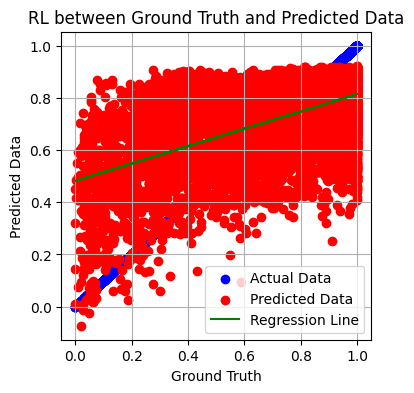

In [15]:
predicted_data = np.array(y_pred)  # Sample predicted data
slope, intercept = np.polyfit(Y_test, predicted_data, 1)
regression_line = slope * Y_test + intercept

# Plot actual data and predicted data
plt.figure(figsize=(4, 4))
plt.scatter(Y_test, Y_test, color='blue', label='Actual Data')
plt.scatter(Y_test, predicted_data, color='red', label='Predicted Data')
plt.plot(Y_test, regression_line, color='green', label='Regression Line')

# Add labels and title
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Data')
plt.title('RL between Ground Truth and Predicted Data')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

## Plot Training and Validation Loss

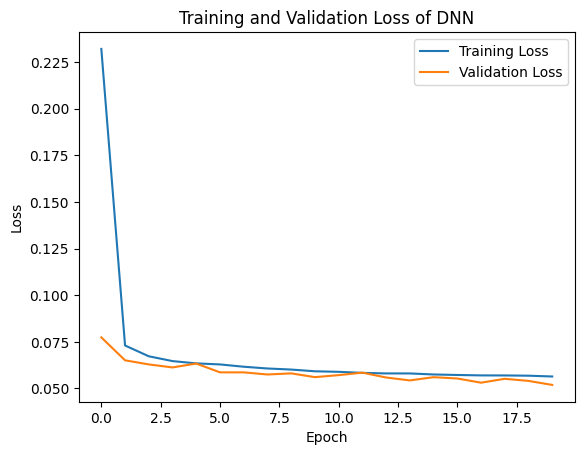

In [17]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss of DNN')
plt.legend()
plt.show()

## Prepare Test DataFrame

In [18]:
test_df = X_test[['DRUG_ID','dose']]
test_df['Actual_Viability'] = Y_test
test_df['Predicted_Viability'] = y_pred

filter = test_df[(test_df.Actual_Viability < 0.5)]
filter

<ipython-input-18-a3ba268a666f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Actual_Viability'] = Y_test
<ipython-input-18-a3ba268a666f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predicted_Viability'] = y_pred


,DRUG_ID,dose,Actual_Viability,Predicted_Viability
31411,1012,1.250000,0.078870,0.388043
89656,1058,3.162555,0.396975,0.464113
48285,1494,0.050000,0.285732,0.482014
57995,1012,5.000000,0.217460,0.228612
96472,1022,1.000176,0.143639,0.743279
...,...,...,...,...
26789,1022,0.500000,0.286875,0.869244
31019,1012,5.000000,0.461066,0.454068
11743,1494,0.050000,0.440288,0.679777
66892,1022,0.500000,0.054175,0.785327


## Calculate IC50

In [19]:
drug_data = test_df[(test_df.DRUG_ID == 1004)]
drug_data

,DRUG_ID,dose,Actual_Viability,Predicted_Viability
3223,1004,0.000391,0.960454,0.751702
15892,1004,0.050000,0.404620,0.903898
40035,1004,0.000100,0.998435,0.723921
44829,1004,0.031626,0.246250,0.695840
35084,1004,0.031626,0.615133,0.862284
...,...,...,...,...
78113,1004,0.025000,0.243998,0.812763
36354,1004,0.100000,0.363472,0.773910
7805,1004,0.001563,0.816969,0.717053
65679,1004,0.010002,0.307666,0.615272


In [20]:
# Calculate the mean of each drug concentration
unique_dose = drug_data.dose.unique()

dic_conc_via = {'Concentration':[],'Actual_Mean':[],'Predicted_Mean':[]}

for val in unique_dose:
  values = drug_data[(drug_data.dose == val)]
  actual_mean = np.mean(values.Actual_Viability)
  predicted_mean = np.mean(values.Predicted_Viability)
  dic_conc_via['Concentration'].append(val)
  dic_conc_via['Actual_Mean'].append(actual_mean)
  dic_conc_via['Predicted_Mean'].append(predicted_mean)

drug_data_df = pd.DataFrame(dic_conc_via)
drug_data_df

,Concentration,Actual_Mean,Predicted_Mean
0,0.000391,0.928971,0.724122
1,0.050000,0.325870,0.757826
2,0.000100,0.974812,0.732252
3,0.031626,0.429976,0.744367
4,0.025000,0.372301,0.757265
5,0.006250,0.595727,0.746139
6,0.010002,0.504824,0.759343
7,0.003163,0.665460,0.753054
8,0.003125,0.783167,0.728383
9,0.000781,0.902691,0.763897


## Logarithmic Function

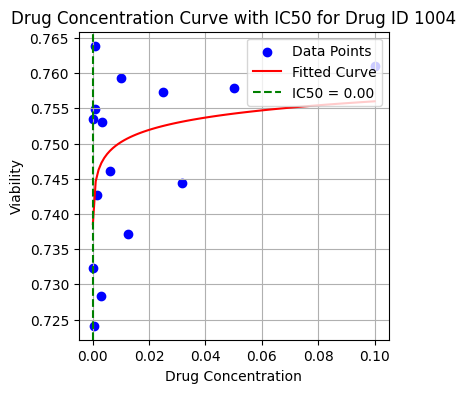

Estimated IC50: 9.1588142597335e-46


In [21]:
dose = drug_data_df.Concentration  # Example dose values
viability = drug_data_df.Predicted_Mean # Example viability values

def logarithmic(x, A, B):
    return A * np.log(x) + B

# Fit the logarithmic curve to the data
popt, pcov = curve_fit(logarithmic, dose, viability)

# Extract the IC50 value
IC50 = np.exp((0.5 - popt[1]) / popt[0])

# Plot the dose-response curve and IC50
plt.figure(figsize=(4, 4))
plt.scatter(dose, viability, color='blue', label='Data Points')

# Generate x values for smooth curve
x_values = np.linspace(min(dose), max(dose), 100)

# Plot the fitted curve
plt.plot(x_values, logarithmic(x_values, *popt), color='red', label='Fitted Curve')

# Plot vertical line for IC50
plt.axvline(x=IC50, color='green', linestyle='--', label=f'IC50 = {IC50:.2f}')
plt.xlabel('Drug Concentration')
plt.ylabel('Viability')
plt.title('Drug Concentration Curve with IC50 for Drug ID 1004')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

print("Estimated IC50:", IC50)

## Linear Function

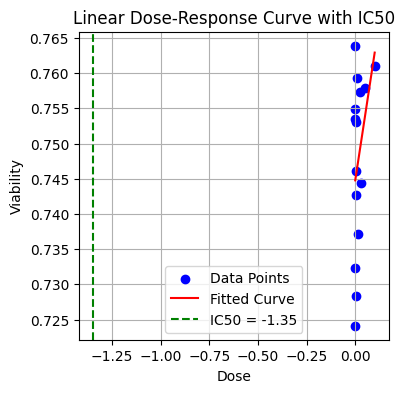

Estimated IC50: -1.3473725383037236


In [22]:
dose = drug_data_df.Concentration
viability = drug_data_df.Predicted_Mean

# Define the linear function
def linear(x, m, c):
    return m * x + c

# Fit the linear curve to the data
popt, pcov = curve_fit(linear, dose, viability)

# Extract the IC50 value
IC50 = (0.5 - popt[1]) / popt[0]

# Plot the dose-response curve and IC50
plt.figure(figsize=(4, 4))
plt.scatter(dose, viability, color='blue', label='Data Points')

# Generate x values for smooth curve
x_values = np.linspace(min(dose), max(dose), 100)

# Plot the fitted curve
plt.plot(x_values, linear(x_values, *popt), color='red', label='Fitted Curve')

# Plot vertical line for IC50
plt.axvline(x=IC50, color='green', linestyle='--', label=f'IC50 = {IC50:.2f}')
plt.xlabel('Dose')
plt.ylabel('Viability')
plt.title('Linear Dose-Response Curve with IC50')
plt.legend()
plt.grid(True)
plt.show()

print("Estimated IC50:", IC50)

In [25]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 16.0 MB/s eta 0:00:00


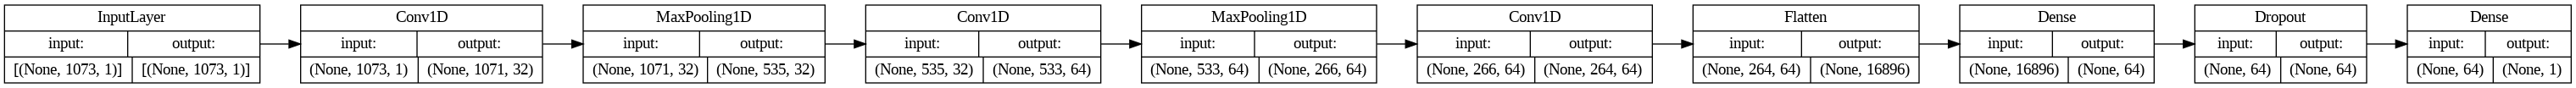

In [35]:
from tensorflow.keras.utils import model_to_dot
from IPython.display import Image

inputdim = X_train.shape[1]
X_train_reshaped = X_train.values.reshape(-1, inputdim, 1)
# X_val_reshaped = X_val.reshape(-1, 1000, 1)

# Define the CNN Architecture for Regression
model = models.Sequential([
    layers.Conv1D(32, 3, activation='relu', input_shape=(inputdim, 1)),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Adding dropout for regularization
    layers.Dense(1)  # Output layer for regression
])

# Assuming you have a model named 'model'
dot_img_file = 'model_architecture.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True, show_layer_names=False, rankdir='LR')

# Display the image
Image(dot_img_file)

# CNN

In [12]:
inputdim = X_train.shape[1]
X_train_reshaped = X_train.values.reshape(-1, inputdim, 1)
# X_val_reshaped = X_val.reshape(-1, 1000, 1)

# Define the CNN Architecture for Regression
model = models.Sequential([
    layers.Conv1D(32, 3, activation='relu', input_shape=(inputdim, 1)),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Adding dropout for regularization
    layers.Dense(1)  # Output layer for regression
])


# model = models.Sequential([
#     layers.Conv1D(32, 3, activation='relu', input_shape=(inputdim, 1)),
#     layers.MaxPooling1D(2),
#     layers.Conv1D(64, 3, activation='relu'),
#     layers.MaxPooling1D(2),
#     # layers.Conv1D(64, 3, activation='relu'),
#     # layers.MaxPooling1D(2),
#     # layers.Conv1D(512, 3, activation='relu'),
#     # layers.GlobalMaxPooling1D(),  # Global max pooling instead of flatten for sequence data
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),  # Adding dropout for regularization
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.5),  # Adding dropout for regularization
#     layers.Dense(1)  # Output layer for regression
# ])


# Compile the Model
model.compile(optimizer='adam',
              loss='mean_squared_error',  # Use MSE for regression
              metrics=['mae'])  # You can add other metrics like MAE for evaluation

# Train the Model
history = model.fit(X_train_reshaped, Y_train, epochs=10, validation_split=0.1, verbose=2)

Epoch 1/10
2809/2809 - 191s - loss: 0.1029 - mae: 0.2622 - val_loss: 0.0783 - val_mae: 0.2374 - 191s/epoch - 68ms/step
Epoch 2/10
2809/2809 - 185s - loss: 0.0776 - mae: 0.2328 - val_loss: 0.0772 - val_mae: 0.2256 - 185s/epoch - 66ms/step
Epoch 3/10
2809/2809 - 189s - loss: 0.0762 - mae: 0.2303 - val_loss: 0.0726 - val_mae: 0.2203 - 189s/epoch - 67ms/step
Epoch 4/10
2809/2809 - 183s - loss: 0.0696 - mae: 0.2169 - val_loss: 0.0632 - val_mae: 0.2061 - 183s/epoch - 65ms/step
Epoch 5/10
2809/2809 - 187s - loss: 0.0659 - mae: 0.2098 - val_loss: 0.0638 - val_mae: 0.2032 - 187s/epoch - 66ms/step
Epoch 6/10
2809/2809 - 182s - loss: 0.0648 - mae: 0.2071 - val_loss: 0.0665 - val_mae: 0.2020 - 182s/epoch - 65ms/step
Epoch 7/10
2809/2809 - 184s - loss: 0.0644 - mae: 0.2064 - val_loss: 0.0618 - val_mae: 0.2041 - 184s/epoch - 65ms/step
Epoch 8/10
2809/2809 - 183s - loss: 0.0639 - mae: 0.2052 - val_loss: 0.0608 - val_mae: 0.1998 - 183s/epoch - 65ms/step
Epoch 9/10
2809/2809 - 179s - loss: 0.0636 - mae

# Evaluate Model Performance

In [16]:
inputdim = X_test.shape[1]
X_test_reshaped = X_test.values.reshape(-1, inputdim, 1)

test_loss = model.evaluate(X_test_reshaped, Y_test)[0]
print(f'MSE Error: {test_loss}')

# Make predictions
y_pred = model.predict(X_test)
rmse = np.sqrt(test_loss)
evs = explained_variance_score(Y_test, y_pred)
mae = mean_absolute_error(Y_test,y_pred)
print('Explain Variance Ratio',evs)
print('RMSE Error',rmse)
print('MAE Error',mae)

235/235 [==============================] - 6s 23ms/step - loss: 0.0636 - mae: 0.1952
MSE Error: 0.06360901892185211
235/235 [==============================] - 4s 16ms/step
Explain Variance Ratio 0.21813217173788424
RMSE Error 0.25220828480018675
MAE Error 0.19518783156240588


In [14]:
y_pred

array([[0.6918153 ],
       [0.6618854 ],
       [0.8333766 ],
       ...,
       [0.8102993 ],
       [0.64684576],
       [0.8378738 ]], dtype=float32)

# Plot Regression Line

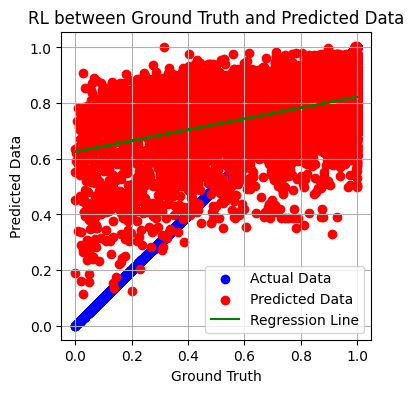

In [17]:
predicted_data = np.array(y_pred)  # Sample predicted data
slope, intercept = np.polyfit(Y_test, predicted_data, 1)
regression_line = slope * Y_test + intercept

# Plot actual data and predicted data
plt.figure(figsize=(4, 4))
plt.scatter(Y_test, Y_test, color='blue', label='Actual Data')
plt.scatter(Y_test, predicted_data, color='red', label='Predicted Data')
plt.plot(Y_test, regression_line, color='green', label='Regression Line')

# Add labels and title
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Data')
plt.title('RL between Ground Truth and Predicted Data')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

# Plot Training and Validation Loss

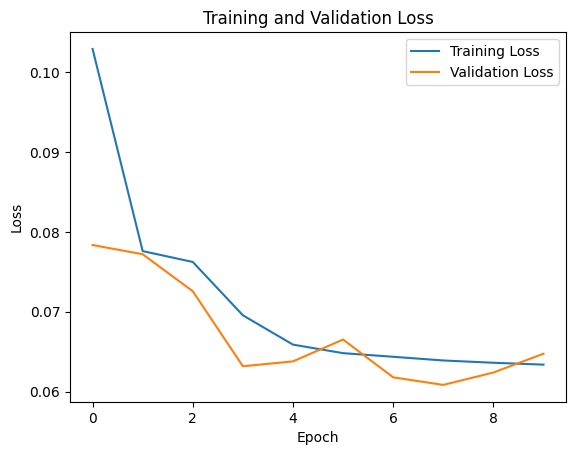

In [18]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Prepare Test DataFrame

In [19]:
test_df = X_test[['DRUG_ID','dose']]
test_df['Actual_Viability'] = Y_test
test_df['Predicted_Viability'] = y_pred

filter = test_df[(test_df.Actual_Viability < 0.5)]
filter

<ipython-input-19-a3ba268a666f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Actual_Viability'] = Y_test
<ipython-input-19-a3ba268a666f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Predicted_Viability'] = y_pred


,DRUG_ID,dose,Actual_Viability,Predicted_Viability
31411,1012,1.250000,0.078870,0.691815
89656,1058,3.162555,0.396975,0.661885
48285,1494,0.050000,0.285732,0.625115
57995,1012,5.000000,0.217460,0.479407
96472,1022,1.000176,0.143639,0.775930
...,...,...,...,...
26789,1022,0.500000,0.286875,0.853418
31019,1012,5.000000,0.461066,0.640572
11743,1494,0.050000,0.440288,0.757630
66892,1022,0.500000,0.054175,0.810299


# Calculate IC50

In [20]:
drug_data = test_df[(test_df.DRUG_ID == 1004)]
drug_data

,DRUG_ID,dose,Actual_Viability,Predicted_Viability
3223,1004,0.000391,0.960454,0.772270
15892,1004,0.050000,0.404620,0.977158
40035,1004,0.000100,0.998435,0.808897
44829,1004,0.031626,0.246250,0.813062
35084,1004,0.031626,0.615133,0.859845
...,...,...,...,...
78113,1004,0.025000,0.243998,0.837282
36354,1004,0.100000,0.363472,0.832480
7805,1004,0.001563,0.816969,0.806968
65679,1004,0.010002,0.307666,0.814089


In [21]:
# Calculate the mean of each drug concentration
unique_dose = drug_data.dose.unique()

dic_conc_via = {'Concentration':[],'Actual_Mean':[],'Predicted_Mean':[]}

for val in unique_dose:
  values = drug_data[(drug_data.dose == val)]
  actual_mean = np.mean(values.Actual_Viability)
  predicted_mean = np.mean(values.Predicted_Viability)
  dic_conc_via['Concentration'].append(val)
  dic_conc_via['Actual_Mean'].append(actual_mean)
  dic_conc_via['Predicted_Mean'].append(predicted_mean)

drug_data_df = pd.DataFrame(dic_conc_via)
drug_data_df

,Concentration,Actual_Mean,Predicted_Mean
0,0.000391,0.928971,0.812870
1,0.050000,0.325870,0.833741
2,0.000100,0.974812,0.828952
3,0.031626,0.429976,0.827918
4,0.025000,0.372301,0.831069
5,0.006250,0.595727,0.829381
6,0.010002,0.504824,0.833814
7,0.003163,0.665460,0.821678
8,0.003125,0.783167,0.818396
9,0.000781,0.902691,0.832924


## Logarithmic Function

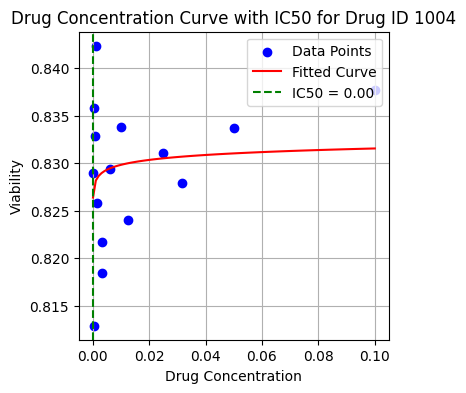

Estimated IC50: 1.281208105016138e-193


In [22]:
dose = drug_data_df.Concentration  # Example dose values
viability = drug_data_df.Predicted_Mean # Example viability values

def logarithmic(x, A, B):
    return A * np.log(x) + B

# Fit the logarithmic curve to the data
popt, pcov = curve_fit(logarithmic, dose, viability)

# Extract the IC50 value
IC50 = np.exp((0.5 - popt[1]) / popt[0])

# Plot the dose-response curve and IC50
plt.figure(figsize=(4, 4))
plt.scatter(dose, viability, color='blue', label='Data Points')

# Generate x values for smooth curve
x_values = np.linspace(min(dose), max(dose), 100)

# Plot the fitted curve
plt.plot(x_values, logarithmic(x_values, *popt), color='red', label='Fitted Curve')

# Plot vertical line for IC50
plt.axvline(x=IC50, color='green', linestyle='--', label=f'IC50 = {IC50:.2f}')
plt.xlabel('Drug Concentration')
plt.ylabel('Viability')
plt.title('Drug Concentration Curve with IC50 for Drug ID 1004')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

print("Estimated IC50:", IC50)

## Linear Function

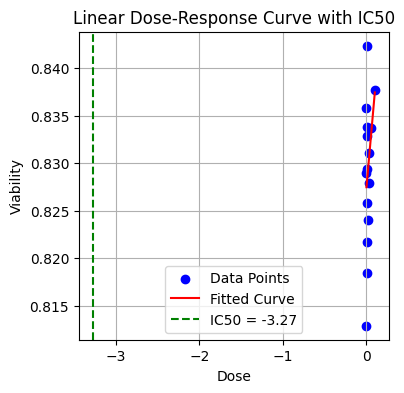

Estimated IC50: -3.2727860301518166


In [23]:
dose = drug_data_df.Concentration
viability = drug_data_df.Predicted_Mean

# Define the linear function
def linear(x, m, c):
    return m * x + c

# Fit the linear curve to the data
popt, pcov = curve_fit(linear, dose, viability)

# Extract the IC50 value
IC50 = (0.5 - popt[1]) / popt[0]

# Plot the dose-response curve and IC50
plt.figure(figsize=(4, 4))
plt.scatter(dose, viability, color='blue', label='Data Points')

# Generate x values for smooth curve
x_values = np.linspace(min(dose), max(dose), 100)

# Plot the fitted curve
plt.plot(x_values, linear(x_values, *popt), color='red', label='Fitted Curve')

# Plot vertical line for IC50
plt.axvline(x=IC50, color='green', linestyle='--', label=f'IC50 = {IC50:.2f}')
plt.xlabel('Dose')
plt.ylabel('Viability')
plt.title('Linear Dose-Response Curve with IC50')
plt.legend()
plt.grid(True)
plt.show()

print("Estimated IC50:", IC50)